In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [ ]:
# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === Ekstrak Dataset ===
zip_file_name = "/content/drive/MyDrive/dataset/dataset-robot"  # Tanpa .zip
!unzip {zip_file_name}.zip

Archive:  /content/drive/MyDrive/dataset/dataset-robot.zip
   creating: dataset/
   creating: dataset/Kursi/
  inflating: dataset/Kursi/image_1.jpeg  
  inflating: dataset/Kursi/image_10.jpeg  
  inflating: dataset/Kursi/image_100.jpeg  
  inflating: dataset/Kursi/image_101.jpeg  
  inflating: dataset/Kursi/image_102.jpeg  
  inflating: dataset/Kursi/image_103.jpeg  
  inflating: dataset/Kursi/image_104.jpeg  
  inflating: dataset/Kursi/image_105.jpeg  
  inflating: dataset/Kursi/image_106.jpeg  
  inflating: dataset/Kursi/image_107.jpeg  
  inflating: dataset/Kursi/image_108.jpeg  
  inflating: dataset/Kursi/image_109.jpeg  
  inflating: dataset/Kursi/image_11.jpeg  
  inflating: dataset/Kursi/image_110.jpeg  
  inflating: dataset/Kursi/image_111.jpeg  
  inflating: dataset/Kursi/image_112.jpeg  
  inflating: dataset/Kursi/image_113.jpeg  
  inflating: dataset/Kursi/image_114.jpeg  
  inflating: dataset/Kursi/image_115.jpeg  
  inflating: dataset/Kursi/image_116.jpeg  
  inflating: da

In [ ]:
# === Path dan Parameter ===
base_dir = "dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20

In [ ]:
# === Data Augmentation + Preprocessing VGG16 ===
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # Ini penting jika tidak ada folder val terpisah
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# === Load Dataset Training dan Validation ===
train_data = data_gen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = data_gen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)

Found 640 images belonging to 4 classes.
Found 160 images belonging to 4 classes.


In [ ]:
# === Kategori Kelas ===
categories = list(train_data.class_indices.keys())
print(f"Detected categories: {categories}")

# === Load VGG16 + Freeze ===
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False

Detected categories: ['Kursi', 'Manusia', 'Meja', 'Pintu']
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# === Build Model ===
model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

# === Compile Model ===
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Training ===
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 753ms/step - accuracy: 0.6042 - loss: 6.1706 - val_accuracy: 0.9563 - val_loss: 0.4950
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 704ms/step - accuracy: 0.9241 - loss: 0.5877 - val_accuracy: 0.9688 - val_loss: 0.2582
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 714ms/step - accuracy: 0.9242 - loss: 0.7306 - val_accuracy: 0.9875 - val_loss: 0.0745
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 722ms/step - accuracy: 0.9575 - loss: 0.4069 - val_accuracy: 0.9750 - val_loss: 0.1863
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 723ms/step - accuracy: 0.9574 - loss: 0.3578 - val_accuracy: 0.9750 - val_loss: 0.2108
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 715ms/step - accuracy: 0.9839 - loss: 0.1052 - val_accuracy: 0.9875 - val_loss: 0.0485
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 727ms/step - accuracy: 0.9745 - loss: 0.2240 - val_accuracy: 0.9812 - val_loss: 0.1665
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 838ms/step - accuracy: 0.9819 - loss: 0.1807 - val_accu

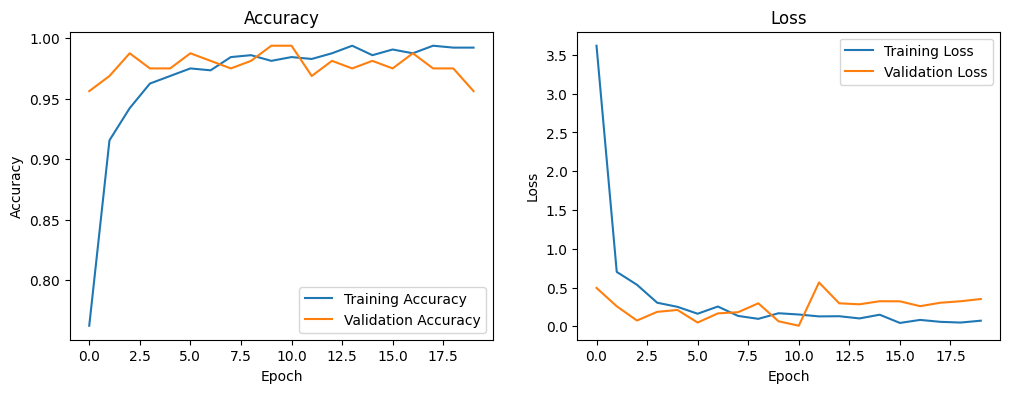

In [ ]:
# === Visualisasi Accuracy dan Loss ===
plt.figure(figsize=(12, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


[INFO] Evaluating the model on validation data...
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 463ms/step
Validation Loss: 0.0642
Validation Accuracy: 0.9937

Classification Report:
              precision    recall  f1-score   support

       Kursi       0.17      0.17      0.17        40
     Manusia       0.22      0.23      0.22        40
        Meja       0.23      0.23      0.23        40
       Pintu       0.23      0.23      0.23        40

    accuracy                           0.21       160
   macro avg       0.21      0.21      0.21       160
weighted avg       0.21      0.21      0.21       160



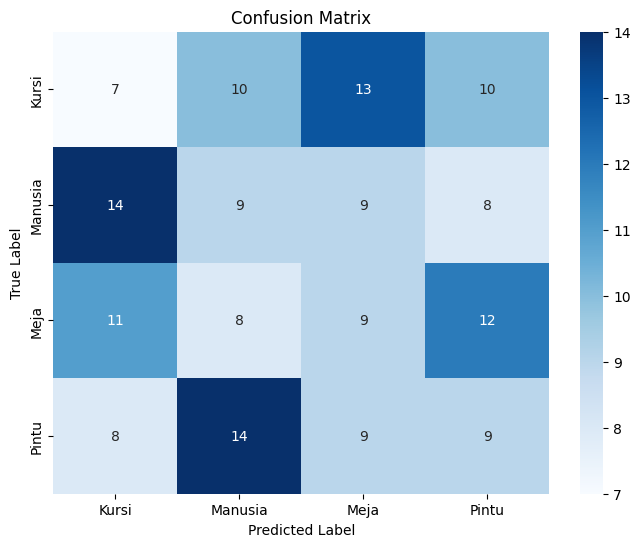

In [ ]:
# === Fungsi Evaluasi Lengkap ===
def evaluate_model(model, data, class_names):
    print("\n[INFO] Evaluating the model on validation data...")

    # Ambil prediksi dan label sebenarnya
    Y_pred = model.predict(data)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = data.classes

    # Akurasi dan Loss
    results = model.evaluate(data, verbose=0)
    print(f"Validation Loss: {results[0]:.4f}")
    print(f"Validation Accuracy: {results[1]:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# === Panggil evaluasi dengan nama kelas ===
evaluate_model(model, val_data, class_names=list(val_data.class_indices.keys()))

In [ ]:
# Model Evaluation
def evaluate_model(model, data):
    print("\nEvaluating the model on test data...")
    results = model.evaluate(data, verbose=1)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    return results

# Evaluate on validation data
evaluate_model(model, val_data)


Evaluating the model on test data...
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.9565 - loss: 0.5265
Test Loss: 0.4101
Test Accuracy: 0.9688


[0.4100676476955414, 0.96875]